### GloVe : Global Vectors for Word Representation) 사용하기
- keras에 내장된 IMDB를 사용하는 대신,(미리 토큰화 되어있음.)
- 원본 텍스트를 다운로드하여 처음부터 시작

In [7]:
# 원본 데이터 다운로드
import os

imdb_dir = './datasets/aclImdb'
train_dir = os.path.join(imdb_dir, 'train')

labels = []
texts = []

for label_type in ['neg', 'pos']: # negative, positive divide
    dir_name = os.path.join(train_dir, label_type)
    for fname in os.listdir(dir_name):
        if fname[-4:] == '.txt':
            f = open(os.path.join(dir_name, fname), encoding='utf8')
            texts.append(f.read())
            f.close()
            if label_type == 'neg':
                labels.append(0)
            else:
                labels.append(1)

- 추후 pre-trained model을 사용할것이기 때문에(데이터수가 적을때 유용한 pre-trained model이라는점)
- 데이터를 200개로 제한한다.

In [8]:
len(texts), len(labels)

(25000, 25000)

In [9]:
# tokenizing
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import numpy as np

maxlen = 100 # 100개 단어 이후는 버린다.
training_samples = 200
validation_samples = 10000 # 검증 데이터는 1만개~
max_words = 10000 # 가장 빈도가 높은 단어 1만개만 사용

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts) # text를 integer의 sequence로 만들어줘!

word_index = tokenizer.word_index
print("%s개의 고유 토큰을 발견하였습니다." % len(word_index))

data = pad_sequences(sequences=sequences, maxlen=maxlen)
labels = np.asarray(labels)
print("데이터 텐서의 크기 : ", data.shape)
print("레이블 텐서의 크기 : ", labels.shape)

indices = np.arange(data.shape[0]) 
np.random.shuffle(indices) # 부정 끝나면 긍정나오기 때문에 섞어준다.
data = data[indices]
labels = labels[indices]

x_train = data[:training_samples]
x_val = data[training_samples:training_samples+validation_samples]

y_train = labels[:training_samples]
y_val = labels[training_samples:training_samples+validation_samples]

88582개의 고유 토큰을 발견하였습니다.
데이터 텐서의 크기 :  (25000, 100)
레이블 텐서의 크기 :  (25000,)


In [13]:
# GloVe 다운로드
# embedding 전처리
glove_dir = './datasets/glove.6B/'

embedding_index = {}
f = open(os.path.join(glove_dir, 'glove.6B.100d.txt'), encoding='utf8')
for line in f: # 한 단어에 대한 100차원 vector
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embedding_index[word] = coefs
f.close()

print("%s개의 단어 벡터를 찾았습니다." % len(embedding_index))

400000개의 단어 벡터를 찾았습니다.


- embedding_index : (단어, embedding coef)

### Embedding Layer에 들어갈 Embedding Matrix 만들자
- embedding matrix : (max_words, embedding_dim)
- embedding matrix의 i번째 원소는 1만개 단어(max_word)중 i번째 단어일 것이고, 
- 이건 해당 단어의 embedding_dim vector가 된다.

In [15]:
embedding_dim = 100
embedding_matrix = np.zeros((max_words, embedding_dim))
for word, i in word_index.items(): # tokenizing된 단어 인덱스
    if i < max_words:
        embedding_vector = embedding_index.get(word) # .get(word)하면 embedding_index의 coefs가 나오겠지
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

In [18]:
# model 정의
# 이전과 동일한 구조 사용
from keras.models import Sequential
from keras.layers import Flatten, Dense, Embedding

model = Sequential()
model.add(Embedding(input_dim=max_words, output_dim=embedding_dim, input_length=maxlen)) # input_length 지정안하면 (None, None, 100)이 output shape
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 100)          1000000   
_________________________________________________________________
flatten_1 (Flatten)          (None, 10000)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                320032    
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 1,320,065
Trainable params: 1,320,065
Non-trainable params: 0
_________________________________________________________________


**Embedding layer의 parameter는 weights뿐!, No biases**

In [21]:
# model에 GloVe 임베딩 로드하기
model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False

In [22]:
# Training
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
hist = model.fit(x=x_train, y=y_train, epochs=10, batch_size=32, validation_data=(x_val, y_val))
model.save_weights('pre_trained_glove_model.h5')

Train on 200 samples, validate on 10000 samples
Epoch 1/10
200/200 [==============================] - 2s 12ms/step - loss: 1.4688 - acc: 0.5200 - val_loss: 1.1884 - val_acc: 0.4990
Epoch 2/10
200/200 [==============================] - 2s 11ms/step - loss: 0.7199 - acc: 0.6200 - val_loss: 0.6874 - val_acc: 0.5567
Epoch 3/10
200/200 [==============================] - 2s 11ms/step - loss: 0.3813 - acc: 0.8850 - val_loss: 0.9981 - val_acc: 0.5007
Epoch 4/10
200/200 [==============================] - 2s 11ms/step - loss: 0.3717 - acc: 0.8100 - val_loss: 0.8463 - val_acc: 0.5081
Epoch 5/10
200/200 [==============================] - 2s 12ms/step - loss: 0.2185 - acc: 0.9450 - val_loss: 0.7799 - val_acc: 0.5270
Epoch 6/10
200/200 [==============================] - 2s 11ms/step - loss: 0.1245 - acc: 1.0000 - val_loss: 0.8850 - val_acc: 0.5274
Epoch 7/10
200/200 [==============================] - 2s 10ms/step - loss: 0.3110 - acc: 0.8450 - val_loss: 0.7183 - val_acc: 0.5636
Epoch 8/10
200/200 [=

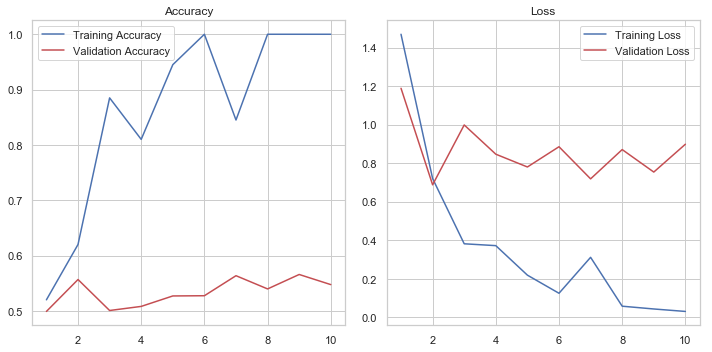

In [25]:
import matplotlib.pyplot as plt

epochs = range(1, len(hist.history['acc']) + 1)

plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
plt.plot(epochs, hist.history['acc'], 'b-', label='Training Accuracy')
plt.plot(epochs, hist.history['val_acc'], 'r-', label='Validation Accuracy')
plt.title("Accuracy")
plt.legend()

plt.subplot(1,2,2)
plt.plot(epochs, hist.history['loss'], 'b-', label='Training Loss')
plt.plot(epochs, hist.history['val_loss'], 'r-', label='Validation Loss')
plt.title("Loss")
plt.legend()

plt.tight_layout()
plt.show()

눈이 의심스러울 정도의 성적이다....